<a href="https://colab.research.google.com/github/Fuenfgeld/Agent_Tutorial_PydanticAI/blob/main/01_IntroductionPydanticAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup Notebook

In [ ]:
%pip -q install pydantic-ai
%pip -q install nest_asyncio
%pip -q install logfire

In [ ]:
import os
from google.colab import userdata

keyAntropic = userdata.get('Claude')
keyOpenAI = userdata.get('openAI')
keyLogFire = userdata.get('logfire')


os.environ["OPENAI_API_KEY"] = keyOpenAI
os.environ["ANTHROPIC_API_KEY"] = keyAntropic

import nest_asyncio
nest_asyncio.apply()

## Agent Setup


PydanticAI is model agnostic and can utilize most LLM models. PydanticAI can use most models either offered via API (openAI, Antropic, Mistral ...) or self-hosted models (llama, deepseek R1 ...). Switching out models is easy and seamless.



### Antropic model

In [ ]:
from pydantic_ai.models.anthropic import AnthropicModel
from pydantic_ai import Agent

claude_model = AnthropicModel('claude-3-5-haiku-latest')
agent = Agent(model=claude_model)

result = agent.run_sync(user_prompt="What are the official languages in Luxembourg")
print(result.output)

### openAI model

In [ ]:
from pydantic_ai import Agent
from pydantic_ai.messages import ModelMessage
from pydantic_ai.models.openai import OpenAIChatModel

openAI_model = OpenAIChatModel('gpt-4o-mini')
agent = Agent(model=openAI_model)

result = agent.run_sync(user_prompt="What are the official languages in Luxembourg")
print(result.output)


## Structured output
Pydantic AI’s core advantage is turning unstructured or semi-structured AI outputs into reliable, validated, and well-typed data-making downstream processing, automation, and integration much safer and easie based on pydantic data classes.Pydantic models enforce strict type and value checks at runtime, ensuring that any data generated or received by your AI application matches the expected structure and types.

In [ ]:
from pydantic import BaseModel, Field

# The docstring is an import it explains to the LLM what the data class is for
class HistoricCelebrity(BaseModel):
    """Historic significant person - includes name,year of birth and short biography"""
    name: str
    birthYear: int
    #the Field function is optional and gives additional instructions to the LLM
    shortBiography: str  = Field(...,description="The short biography should be structured first giving a short text about the person followed by a chronological list of the main events in the life of the celebrity")


# Define the agent
agent = Agent(model=openAI_model, output_type=HistoricCelebrity)

# Run the agent
result = agent.run_sync("who is Florence Nightingale?")


In [ ]:
print(f"""
type of result {type(result.output)}
Name of celebrity {result.output.name} data type: {type(result.output.name)}
Birth date {result.output.birthYear} data type: {type(result.output.birthYear)}
Short biography {result.output.shortBiography} data type: {type(result.output.shortBiography)}
      """)

### Exercise 1: Structured Output with PydanticAI
In this exercise, you'll create a structured output model for medical conditions.

In [ ]:
# Exercise 1: Creating Structured Medical Information
# Instructions:
# 1. Complete the MedicalCondition class using BaseModel
# 2. Set up your preferred model (OpenAI or Anthropic)
# 3. Create an agent that returns structured information about medical conditions
# 4. Test your agent with different medical conditions

from pydantic import BaseModel, Field
from pydantic_ai import Agent
from pydantic_ai.models.openai import OpenAIModel
from typing import List


# TODO: Complete this Pydantic model for medical conditions
class MedicalCondition(BaseModel):
    """Information about a medical condition or disease"""
    name: str
    # TODO: Add fields for symptoms (list of strings)
    causes: str
    symptoms: List[str]


# TODO: Set up your preferred model

# TODO: Create an agent with your model and the MedicalCondition result type
agent = Agent(model=openAI_model, output_type=MedicalCondition)


# TODO: Test your agent with a medical condition query
result = agent.run_sync("What is diabetes mellitus?")

# TODO: Print the structured output
print(f"Name: {result.output.symptoms}")
# Print other fields...

## Agent Concepts
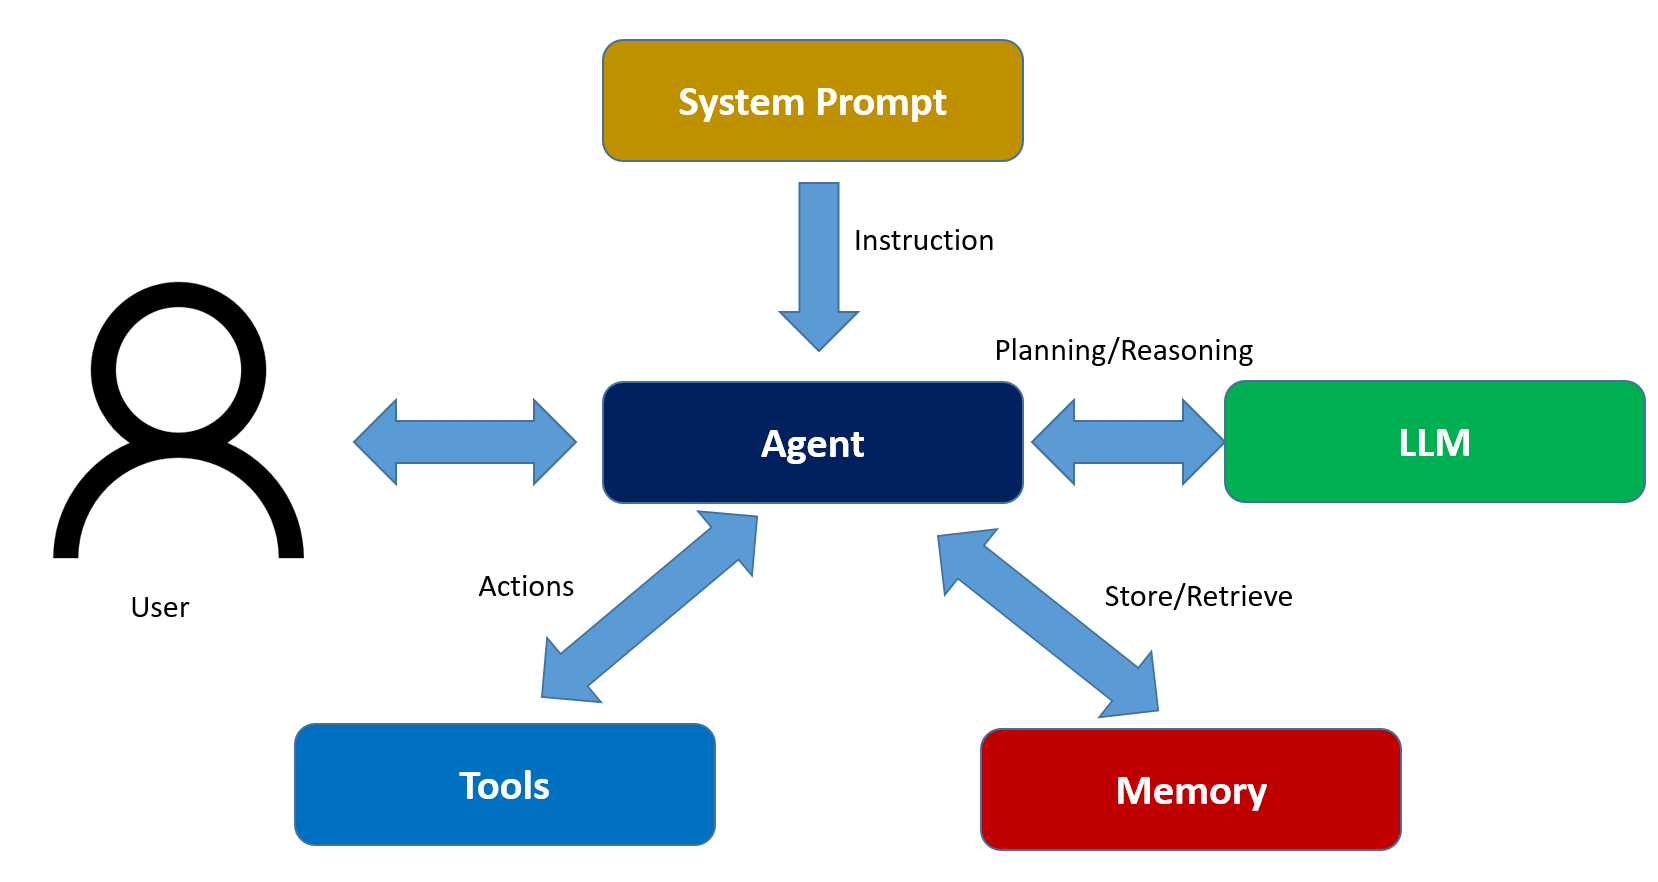

## System Prompt

System prompts set the overall context, tone, and objectives for the AI, essentially telling it "who it is" and "how it should act." For example, assigning a role like "helpful assistant" or "technical expert" through a system prompt gives the AI a framework for generating relevant and coherent responses. Dynamic system prompts significantly enhance AI responses by making AI interactions more personalized and context-aware.

In [ ]:
from pydantic_ai import Agent, RunContext
from datetime import date

agent = Agent(
    model=openAI_model,
    deps_type=str,
    system_prompt="Use the user name while replying to them.",
)

# system prompts can be altered using decorators
#here information about the run context like session ids can be injected
@agent.system_prompt
def add_user_name(ctx: RunContext[str]) -> str:
    return f"The user name is {ctx.deps}."

# here current information can be added
@agent.system_prompt
def add_the_date() -> str:
    return f'The date is {date.today()}.'

result = agent.run_sync('What is the date today?', deps='Max')
print(result.output)

## Tools

Tools in Pydantic AI are functions that the language model (LLM) can call to retrieve extra information or perform specific actions to help generate a response. They are especially useful when the model needs to access data or capabilities beyond its own training or context, such as:

  *  Fetching up-to-date or external information (e.g., weather, database lookups)

  * Performing calculations or transformations

  * Accessing APIs or custom business logic



When an agent is configured with tools, the LLM can decide to "call" these tools during a conversation. The results from these tool calls are then incorporated into the AI's response, making the agent more powerful, interactive, and capable of handling complex tasks that go beyond simple text generation

In [ ]:
import random

agent = Agent(
    model=openAI_model,
    deps_type=str,
    system_prompt="you are a lab assistant giving patient their lab results and explain the result",
)

@agent.tool_plain
def getLabResult() -> str:
    """Get the Calcium level """
    return "1.45 mmol/L"

@agent.tool
def getPatientName(ctx: RunContext[str]) -> str:
    """Get the patient names"""
    return ctx.deps

result = agent.run_sync('What is my Calcium level', deps='Max')
print(result.output)

### Exercise 2: System Prompts and Tools
In this exercise, you'll create a medical reference agent with specialized tools.

In [ ]:
# Exercise 2: Medical Reference Agent with Tools
# Instructions:
# 1. Create an agent that acts as a medical reference tool
# 2. Add system prompts to define the agent's behavior
# 3. Implement tools to provide additional medical information
# 4. Test the agent with health-related questions

from pydantic_ai import Agent, RunContext
from pydantic_ai.models.openai import OpenAIChatModel

# TODO: Set up your preferred model
model = OpenAIChatModel('gpt-4o-mini')

# TODO: Create an agent with a system prompt that makes it a medical reference
agent = Agent(
     model=model,
     system_prompt="You are a medical assistant that acts to give health advice based on BMI "
 )

# TODO: Implement a tool to provide BMI calculation
@agent.tool_plain
def calculate_bmi(weight_kg: float, height_m: float) -> float:
    """Calculate BMI (Body Mass Index) given weight in kg and height in meters"""

    return (weight_kg/height_m**2)


# TODO: Implement a tool to convert units commonly used in medicine
@agent.tool_plain
def convert_units(inUntis:str) -> str: # YOUR CODE HERE
    """Convert between medical units (e.g., mg to g, celsius to fahrenheit)"""
    agentConv = Agent(
     model=model,
     system_prompt="You are a medical assistant that converts between medical units ")
    result = agentConv.run_sync(f"Convert this unit {inUntis} into another medical unit")
    return result.output

# TODO: Add a system prompt decorator that adds context about medical accuracy
@agent.system_prompt
def medical_accuracy() -> str:
    return "give accurate information"

# TODO: Test your medical reference agent
result = agent.run_sync("What's a normal BMI range? can you give the bmi for a patient weigth 67kg and hight 1.70 m in imperial units")
print(result.output)

## Memory
LLMS are stateless and all previous messages need to be submitted to an LLM calls for the LLM to keep memory.
memory refers to the agent’s ability to retain and access previous messages or conversation history during interactions. This memory is typically managed as a list of message objects (such as user requests and model responses) that are passed to the agent at runtime in pydanticAI this is message_history variable. The memory can be short-term (only available during an active session) or long-term (persisted to disk or a database for retrieval in future sessions).

In [ ]:
from pydantic_ai import Agent
from pydantic_ai.messages import (ModelMessage)
from pydantic_ai.models.openai import OpenAIModel


agent = Agent(model=openAI_model,
    system_prompt="you are a funny pirate",
)


def main_loop():
    message_history: list[ModelMessage] = []

    while True:
        user_input = input("> ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("finish")
            break

        # Run the agent
        result = agent.run_sync(user_input, deps=user_input, message_history=message_history)
        print(result.output)
        msg = result.new_messages()
        message_history.extend(msg)

main_loop()

## Developing and Debugging with logfire

logfire is a platform that helps you debug Agent systems. It is tightly integrated with pydanticAI and helps you with logging, tracing, and debugging.

In [ ]:
 import logfire

# Configure logfire
logfire.configure(token=keyLogFire)

# Send a log
logfire.info('System check, thanks good its {date}', date='Friday')

### Spans
Logfire spans are the building blocks of traces in the Logfire observability platform. A span represents a single unit of work or operation within your application, allowing you to measure the execution time of code and add contextual information to your logs. Each span can be thought of as a log entry with extra capabilities-specifically, timing and context

In [ ]:
with logfire.span('Calling Agent') as span:
    result = agent.run_sync("What are the official languages in Luxembourg")
    span.set_attribute('result', result.output)
    logfire.info('{result=}', result=result.output)

### Logging Levels

The next example uses the Logfire API to log the same result at several different severity levels. Each line is a logging statement, but the log level determines how important or critical the message is in the context of your application. Logfire supports multiple log levels, including notice, info, debug, warn, error, and fatal.
Here’s what each level means and when you might use it:
* notice: For significant, but not urgent, events that should be highlighted for operators or administrators.
* info: For routine information about the application's operation, typically confirming that things are working as expected.
* debug: For detailed diagnostic messages, usually only enabled during development or troubleshooting.
* warn: For potentially harmful situations that are not immediately critical but may cause problems.
* error: For serious problems that prevent some operation from completing.
* fatal: For very severe errors that will likely cause the application to terminate.





In [ ]:
with logfire.span('Calling Agent') as span:
    result = agent.run_sync("What are the official languages in Luxembourg")
    logfire.notice('{result=}', result=result.output)
    logfire.info('{result=}', result=result.output)
    logfire.debug('{result=}', result=result.output)
    logfire.warn('{result=}', result=result.output)
    logfire.error('{result=}', result=result.output)
    logfire.fatal('{result=}', result=result.output)

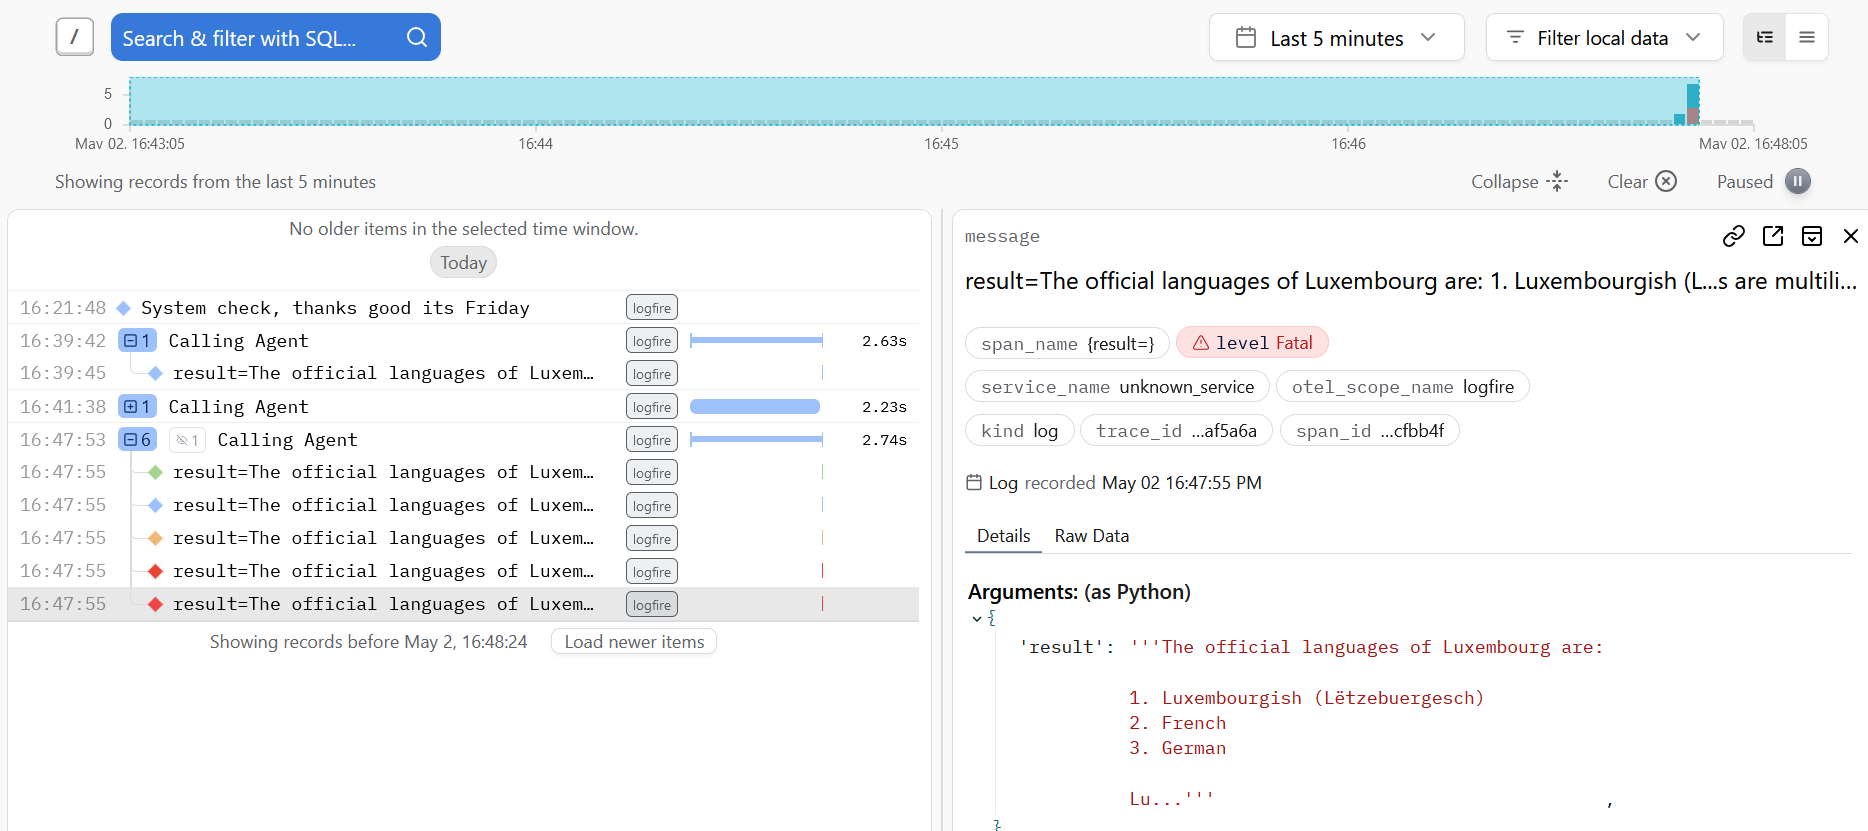

### Logging Exceptions
The record_exception function attaches details of an exception (such as its type, message, and stack trace) to a Logfire span. This makes it easy to see errors and their context within the application’s traces when monitoring or debugging.

In [ ]:
with logfire.span('Calling Agent') as span:
    try:
        result = agent.run_sync("what is LOINC")
        raise ValueError(result.output)
    except ValueError as e:
        span.record_exception(e)

### Exercise 3: Memory and Logging
In this exercise, you'll create a patient consultation agent that maintains conversation history.

In [ ]:
# Exercise 3: Patient Consultation with Memory and Logging
# Instructions:
# 1. Create an agent that simulates a medical consultation
# 2. Implement a chat interface that maintains conversation history
# 3. Add logfire spans and logging for tracking the conversation
# 4. Test with a multi-turn patient conversation

from pydantic_ai import Agent
from pydantic_ai.messages import ModelMessage
from pydantic_ai.models.openai import OpenAIModel
import logfire

# TODO: Configure logfire if you have a token
# logfire.configure(token=your_token_here)

# TODO: Create an agent with a physician role
# model = OpenAIModel('gpt-4o-mini')
# agent = Agent(
#     model=model,
#     system_prompt=""
# )

# TODO: Implement the patient consultation loop
def patient_consultation():
    message_history: list[ModelMessage] = []

    print("Virtual Doctor Consultation (type 'exit' to end)")
    print("What brings you in today?")

    while True:
        # TODO: Get patient input

        # TODO: Exit if patient types 'exit' or 'quit'

        # TODO: Use logfire to create a span for this interaction
        # with logfire.span("Patient Interaction") as span:

            # TODO: Run the agent with the patient input and message history

            # TODO: Log the interaction at appropriate severity level

            # TODO: Print the physician's response

            # TODO: Update message history with new messages

        pass

# TODO: Run your patient consultation
# patient_consultation()